In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers.legacy import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras.layers import ReLU
from keras.layers import Add
import pandas as pd
import os
from icecream import ic
import numpy as np
import cv2

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64, 64, 3), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample to 32x32x64
    fe = Conv2D(64, (5,5), strides=(2,2), padding='same')(merge)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16x128
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 8x8x128
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    # fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_discriminator_256(in_shape=(256, 256, 3), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    df_dim = 64
    # downsample to 128x128xdf_dim
    fe = Conv2D(df_dim, (4,4), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 64x64xdf_dim*2
    fe = Conv2D(df_dim*2, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 32x32xdf_dim*4
    fe = Conv2D(df_dim*4, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 16x16xdf_dim*8
    fe = Conv2D(df_dim*8, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 8x8xdf_dim*16
    fe = Conv2D(df_dim*16, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*32
    fe = Conv2D(df_dim*32, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*16
    fe = Conv2D(df_dim*16, (1,1), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample to 4x4xdf_dim*8
    fe = Conv2D(df_dim*5, (1,1), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [3]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 8 * 8
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((8, 8, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 8 * 8 * 512
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8, 8, 512))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to  16x16x256 (14x14)
    gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to  32x32x128 (14x14)
    gen = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 64x64x64 (28x28)
    gen = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output 64x64x3
    out_layer = Conv2D(3, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

def residual_block(in_vec):
    gf_dim = 128
    # Store input vector for later addition
    identity = in_vec   # 16x16xgf_dim*4
    # Resample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(in_vec)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    # Resample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(fe)
    fe = BatchNormalization()(fe)

    # Add input vector
    output = Add()([identity, fe])
    output = ReLU()(output)

    return output

# define the standalone generator model
def define_generator_256(in_shape=(64, 64, 3), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 16 * 16 * 128
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((16, 16, 128))(li)

    # image input encoding
    in_image = Input(shape=in_shape)
    gf_dim = 128
    # downsample to 64x64xgf_dim
    fe = Conv2D(gf_dim, (3,3), strides=(1,1), padding='same')(in_image)
    fe = ReLU()(fe)
    # downsample to 32x32xgf_dim*2
    fe = Conv2D(gf_dim*2, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)
    # downsample to 16x16xgf_dim*4
    fe = Conv2D(gf_dim*4, (4,4), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = ReLU()(fe)

    # Merge image and class embedings
    merge = Concatenate()([fe, li])     # 16x16x(128+gf_dim*4)
    # downsample to 16x16xgf_dim*4
    merge = Conv2D(gf_dim*4, (3,3), strides=(1,1), padding='same')(merge)
    merge = BatchNormalization()(merge)
    merge = ReLU()(merge)

    # Residual blocks
    rb = residual_block(merge)
    rb = residual_block(rb)
    rb = residual_block(rb)
    rb = residual_block(rb)     # 16x16xgf_dim*4

    # Generator
    # upsample to  32x32xgf_dim*2
    gen = Conv2DTranspose(gf_dim*2, (5,5), strides=(2,2), padding='same')(rb)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  64x64xgf_dim
    gen = Conv2DTranspose(gf_dim, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  128x128xgf_dim//2
    gen = Conv2DTranspose(gf_dim//2, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)
    # upsample to  256x256xgf_dim//4
    gen = Conv2DTranspose(gf_dim//4, (5,5), strides=(2,2), padding='same')(gen)
    gen = BatchNormalization()(gen)
    gen = ReLU()(gen)

    # output 256x256x3
    out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_image, in_label], out_layer)
    return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan_256(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_img, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_img, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [5]:
def process_images(dataframe, target_size=(64, 64), size_256 = (256, 256)):
    processed_images = []
    images_256 = []

    for i, row in dataframe.iterrows():
        current_path = os.getcwd()
        img_path = os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'images', row['filepath'])
        if not os.path.exists(img_path):
            continue  # skip if file does not exist

        # Read the image
        img = cv2.imread(img_path)

        # Crop the image
        x, y, w, h = row['box_x'], row['box_y'], row['box_w'], row['box_h']
        crop_img = img[int(y):int(y+h), int(x):int(x+w)]
        crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
        # resize_img = cv2.resize(crop_img, target_size)
        # processed_images.append(resize_img)

        # # Augment data
        transforms = [
            [0, h, 10, w],
            [10, h, 10, w],
            [10, h, 0, w-10],
            [0, h-10, 10, w],
            [0, h-10, 0, w-10],
            [10, h-10, 10, w-10]
        ]
        # transforms = np.array(transforms).astype('int')
        for i, t in enumerate(transforms):
            aug_img = crop_img[int(t[0]):int(t[1]), int(t[2]):int(t[3])]
            resized_img = cv2.resize(aug_img, target_size)
            fliped_img = cv2.flip(resized_img, 1)
            processed_images.append(resized_img)
            processed_images.append(fliped_img)

            resized_img_256 = cv2.resize(aug_img, size_256)
            fliped_img_256 = cv2.flip(resized_img_256, 1)
            images_256.append(resized_img_256)
            images_256.append(fliped_img_256)

    return np.array(processed_images), np.array(images_256)

# load CUB dataset images
def load_real_birds():
    # Load data
    current_path = os.getcwd()
    images = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'images.txt'), sep=' ',
                            names=['img_id', 'filepath'])
    image_class_labels = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'image_class_labels.txt'),
                                        sep=' ', names=['img_id', 'target'])
    train_test_split = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'train_test_split.txt'),
                                    sep=' ', names=['img_id', 'is_training_img'])
    bounding_boxes = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'bounding_boxes.txt'),
                                    sep=' ', names=['img_id', 'box_x', 'box_y', 'box_w', 'box_h'])
    parts_locs = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'parts', 'part_locs.txt'),
                                    sep=' ', names=['img_id', 'part_id', 'part_x', 'part_y', 'visible'])
    # ic(parts_locs.shape)
    # atributes = pd.read_csv(os.path.join(current_path, 'CUB_200_2011', 'CUB_200_2011', 'attributes', 'image_attribute_labels.txt'),
    #                                 sep=' ', names=['img_id', 'attribute_id', 'is_present', 'certainty_id', 'time'])
    # ic(atributes.shape)
    data = images.merge(image_class_labels, on='img_id')
    data = data.merge(train_test_split, on='img_id')
    data = data.merge(bounding_boxes, on='img_id')
    # data = data.merge(parts_locs, on='img_id')
    ic(data.shape)

    # Filter dataset to only 10 classes
    targeted_classes = [12, 14, 16, 17, 18, 19, 20, 29, 42, 47]
    data = data[data["target"].isin(targeted_classes)]
    ic(data.shape)

    # Load and process images
    image_data, image_data_256 = process_images(data)
    image_data = image_data.astype('float32')
    image_data_256 = image_data_256.astype('float32')
    image_data = (image_data - 127.5) / 127.5
    image_data_256 = (image_data_256 - 127.5) / 127.5
    ic(image_data.shape)
    
    # Replace original labels by new labels to 10
    labels = []
    labels_256 = []
    l_new = 0
    l_last = -1
    for i, l in enumerate(data.values[:, 2]):
        if l != l_last:
            l_new += 1
            l_last = l
        for j in range(12):
            labels.append(l_new)
            labels_256.append(l_new)
    # labels = data.values[:, 2].reshape((-1, 1)).astype('float32')
    labels = np.array(labels).reshape((-1, 1)).astype('float32')
    labels_256 = np.array(labels_256).reshape((-1, 1)).astype('float32')

    return [image_data, labels], parts_locs, [image_data_256, labels_256]

dataset, parts, dataset_256 = load_real_birds()
# ic(dataset[0].shape, dataset[1].shape, dataset_256[0].shape, dataset_256[1].shape)


ic| data.shape: (11788, 8)
ic| data.shape: (574, 8)
ic| image_data.shape: (6888, 64, 64, 3)


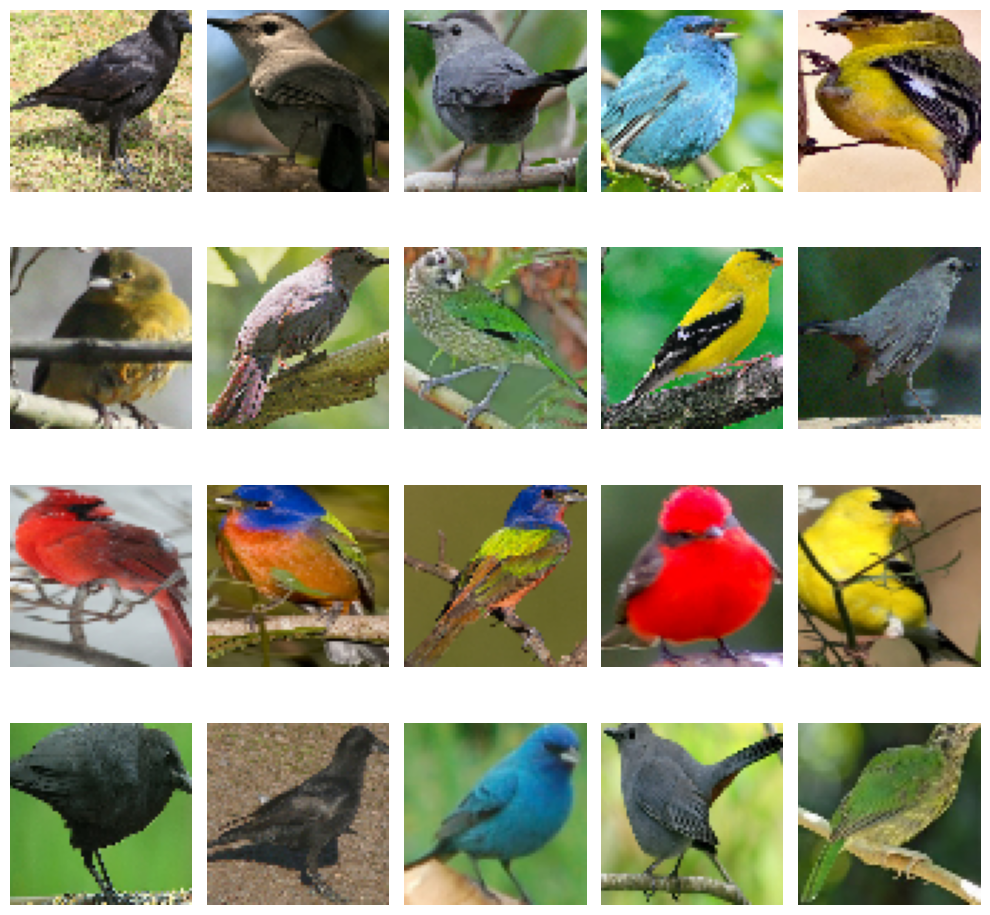

In [6]:
from matplotlib import pyplot
# create and save a plot of generated images
def save_plot(examples, n, m):
    examples = (examples + 1) / 2
    fig, axes = pyplot.subplots(n, m, figsize=(10,10))
    axes = axes.flatten()
    # plot images
    for ax, img in zip(axes, examples):
        # define subplot
        # pyplot.subplot(n, m, 1 + i)
        ax.imshow(img)
        # turn off axis
        ax.axis('off')
        # plot raw pixel data
        # pyplot.imshow((examples[i, :, :, :]))
    pyplot.tight_layout()
    pyplot.show()
ix = randint(0,dataset[0].shape[0], 20)
save_plot(dataset[0][ix], 4, 5)

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# [X_real, labels_real], y_real = generate_real_samples(dataset, 64)

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # ic(x_input)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(1, n_classes, n_samples)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_256(generator, generator_256, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # predict outputs of size 256
    images = generator_256.predict([images, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [9]:
# train the Stage I generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if ((i+1) % 10) == 0:
            g_model.save(f'models/stackgan_generator_birds_10_color_aug_{i+1}.h5')
            d_model.save(f'models/stackgan_discriminator_birds_10_color_aug_{i+1}.h5')
            gan_model.save(f'models/stackgan_gan_birds_10_color_aug_{i+1}.h5')

    # save the generator model
    g_model.save('models/stackgan_generator_birds_10_color_aug.h5')
    d_model.save(f'models/stackgan_discriminator_birds_10_color_aug.h5')
    gan_model.save(f'models/stackgan_gan_birds_10_color_aug.h5')


# train the Stage II generator and discriminator
def train_256(g_model, g_model_256, d_model_256, gan_model_256, dataset_256, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset_256[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
    # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset_256, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model_256.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples_256(g_model, g_model_256, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model_256.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input], y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model_256.train_on_batch([z_input, labels_input], y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if ((i+1) % 10) == 0:
            g_model_256.save(f'models/stackgan_generator_256_birds_10_color_aug_{i+1}.h5')
            d_model_256.save(f'models/stackgan_discriminator_256_birds_10_color_aug_{i+1}.h5')
            gan_model_256.save(f'models/stackgan_gan_birds_256_10_color_aug_{i+1}.h5')

    # save the generator model
    g_model_256.save(f'models/stackgan_generator_256_birds_10_color_aug.h5')
    d_model_256.save(f'models/stackgan_discriminator_256_birds_10_color_aug.h5')
    gan_model_256.save(f'models/stackgan_gan_birds_256_10_color_aug.h5')


In [ ]:
# Define models for the Stage I training
from keras.utils import disable_interactive_logging, enable_interactive_logging
from keras.models import load_model
disable_interactive_logging()

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# d_model = load_model('models/cdcgan_discriminator_birds_10_color_aug_20.h5')
# create the generator
g_model = define_generator(latent_dim)
# g_model = load_model('models/cdcgan_generator_birds_10_color_aug_20.h5')
# create the gan
gan_model = define_gan(g_model, d_model)
# gan_model = load_model('models/cdcgan_gan_birds_10_color_aug_20.h5')

In [ ]:
# Define models for the Stage II training
from keras.utils import disable_interactive_logging, enable_interactive_logging
from keras.models import load_model
disable_interactive_logging()

latent_dim = 100
g_model = load_model('GUI/birds_generator.h5')
d_model_256 = define_discriminator_256()
g_model_256 = define_generator_256()
gan_model_256 = define_gan_256(g_model_256, d_model_256)

In [ ]:

# train Stage I
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10)

In [ ]:
# Train Stage II
train_256(g_model, g_model_256, d_model_256, gan_model_256, dataset_256, latent_dim, n_epochs=10)

2024-01-15 15:07:03.875042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


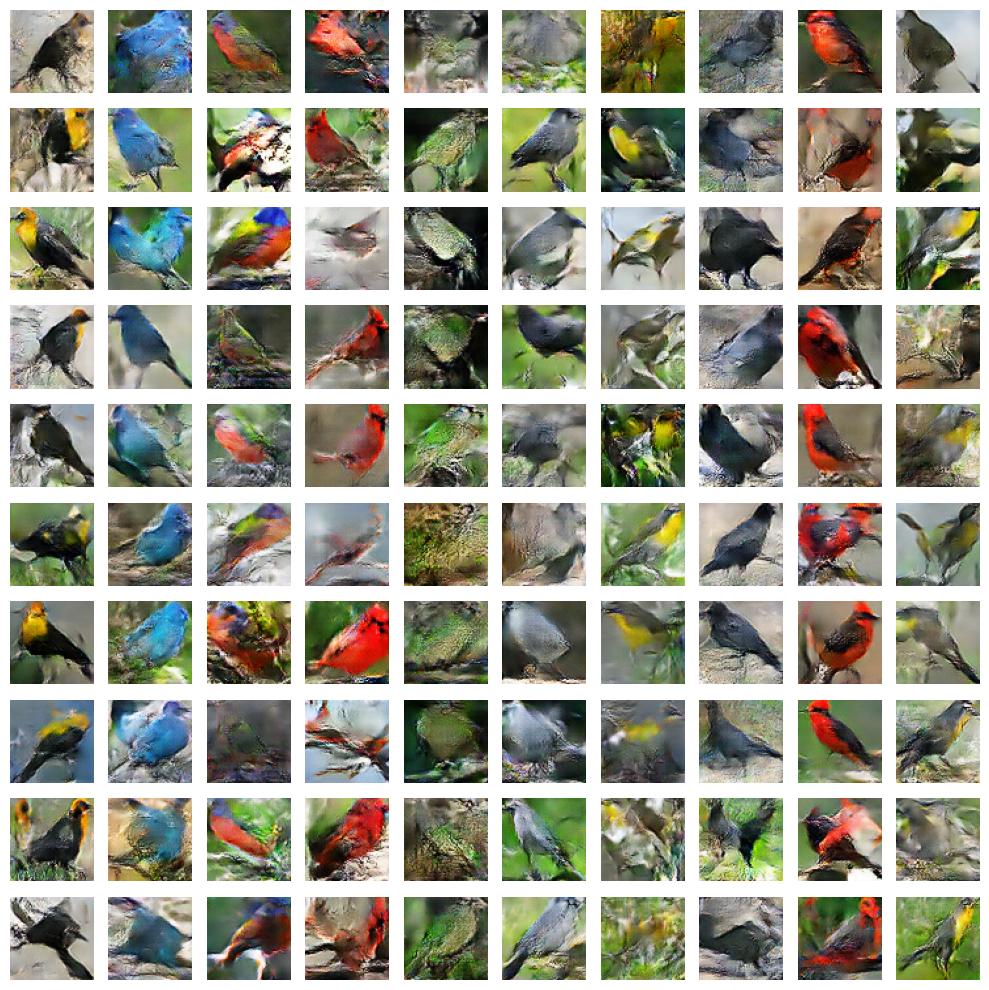

In [12]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model

 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# load model
model = load_model('GUI/birds_generator.h5')
# generate images
n_samples = 100
latent_points, labels = generate_latent_points(latent_dim=100, n_samples=n_samples)
# specify labels
labels = asarray(list(range(1, 11)) * (n_samples//10))
# generate images
X  = model.predict([latent_points, labels])
# Potential Stage II
# model_256 = load_model('models/stackgan_generator_256_birds_10_color_aug.h5')
# Y = model_256.predict([X, labels])
# plot the result
save_plot(X, 10, 10)

In [15]:
# Evaluation using FID score
import tensorflow_gan as tfgan
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3

def get_fid_score(real_image, gen_image):
    inc_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    size = tfgan.eval.INCEPTION_DEFAULT_IMAGE_SIZE

    resized_real_images = tf.image.resize(real_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    resized_generated_images = tf.image.resize(gen_image, [size, size], method=tf.image.ResizeMethod.BILINEAR)
    num_inception_images = real_image.shape[0]
    num_batches = num_inception_images // 100
    fid = tfgan.eval.frechet_classifier_distance(resized_real_images, resized_generated_images, inc_model, num_batches=num_batches)
    return fid.numpy()

model = load_model('GUI/birds_generator.h5')
# generate images
n_samples = 100
n_recalc = 10
fid = 0
for i in range(n_recalc):
    latent_points, labels = generate_latent_points(latent_dim=100, n_samples=n_samples)
    # specify labels
    labels = asarray(list(range(1, 11)) * (n_samples//10))
    # generate images
    X  = model.predict([latent_points, labels])

    fake_imgs = (X + 1) / 2
    [real_imgs, _], _ = generate_real_samples(dataset, n_samples)
    real_imgs = (real_imgs + 1) / 2
    fid += get_fid_score(real_imgs, fake_imgs)
fid /= n_recalc
print(fid)


193.479736328125
